In [1]:
import gym
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import pandas as pd
import gc
import os


In [2]:
#print(np.__config__.show())

In [3]:
# os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
# os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
# os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
# os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
# os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

In [4]:
import numpy as np 
import time

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs: 1


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [7]:
import sys
print(sys.executable)

c:\Users\prati\AppData\Local\Programs\Python\Python39\python.exe


In [8]:

GAMMA = 0.99
LEARNING_RATE = 1e-5

MEMORY_SIZE = 1000000
BATCH_SIZE = 32

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.98

In [9]:
state_space=2
obs_space=1
action_space=3
intermediate_dim=16

In [10]:
#env = gym.make('MountainCar-v0')

from mountain_car import MountainCarEnv
env=MountainCarEnv()


In [11]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,state_space)))
        model.add(Dense(512,activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])
        return model

In [12]:
class DQNSolver:
    def __init__(self, state_space,action_space, decay_coe = 0.99975, 
                  memory_size = 10_000,  C = 5):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel((1,self.states), self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=EXPLORATION_DECAY
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
           #print(X.shape,"   ",y.shape  )                          
            #loss = self.model.Qpolicy.fit(final_dataset,verbose=0)   
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
           # print(self.model.Qpolicy.predict_on_batch(X))
           #print(X.shape,"   ",y.shape  )                          
            loss = self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            
            #self.history.append(loss.history['loss'][0])
            
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [13]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,state_space, intermediate_dim):
    super(Encoder, self).__init__()
    self.input_layer=tf.keras.layers.InputLayer(input_shape=(6,))
    self.hidden_layer1=tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform',activity_regularizer=tf.keras.regularizers.L1(0.001)
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=state_space,
      activation=tf.keras.activations.linear,activity_regularizer=tf.keras.regularizers.L1(0.001)
    )
    
  def call(self, input_features):
    activation0=self.input_layer(input_features)
    activation1 = self.hidden_layer1(activation0)
    #activation1=self.batchnorm_layer1(activation0)
    activation2=self.hidden_layer2(activation1)
    #activation2=self.batchnorm_layer2(activation1)
    return self.output_layer(activation2)

In [14]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


In [15]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, obs_space):
    super().__init__()
    self.hidden_layer1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=obs_space,
      activation=tf.keras.activations.linear
    )
  
  def call(self, input_features,var):
    if(len(input_features.get_shape())==2):
      activation1 = self.hidden_layer1(tf.concat((input_features,var),axis=1))
    else:
      temp=[]
      for i in range(len(input_features)):
          temp.append(tf.concat((input_features[i],var[i]),axis=1))
      temp=tf.convert_to_tensor(temp)
      activation1 = self.hidden_layer1(temp)
    #activation2=self.batchnorm_layer1(activation1)
    activation2=self.hidden_layer2(activation1)
    #activation4=self.batchnorm_layer2(activation3)

    return self.output_layer(activation2)

In [16]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, state_space,obs_space):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(intermediate_dim=intermediate_dim,state_space=state_space)
    
    self.decoder = Decoder(
      intermediate_dim=intermediate_dim,
      obs_space=obs_space
    )
    
  
  def call(self, input_features,var):
    code = self.encoder(input_features)
    #self.var=tf.Variable(var,trainable=False)
    reconstructed = self.decoder(code,var)
    return reconstructed


opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [17]:

def loss(model,input_features, obs,var):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(input_features,var), obs)))
  return reconstruction_error
  
def train(loss, model, opt,input_features,obs,var):
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model,input_features, obs,var), model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)

In [18]:
obs=env.reset()
obs

(array([-0.5771437,  0.       ], dtype=float32), {})

In [19]:
autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  state_space=state_space,obs_space=obs_space
)


In [20]:
autoencoder.weights

[]

In [21]:
def get_obs(state):
    return [state[0]]

In [22]:
def data_collection(total_episodes,dqn_solver,autoencoder):

    S_series=[]
    S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0]]))
    encoder=autoencoder.encoder
    decoder=autoencoder.decoder

    ep_no=0
    i=0
    while(ep_no<total_episodes):
        s0=env.reset()
        s0=s0[0]
        #s0=np.reshape(s0,[1,state_space])
        
        step=0
        done=False
        for t in range(200):
            if(step==0):
                s=s0
                S_actual_series.append(s)
            else:
                s=encoder(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                s=np.reshape(s,(1,state_space))
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                

            s=np.reshape(s,(1,state_space))
            S_series.append(s)
            action=dqn_solver.act(s)

            obs, reward, done, info ,_= env.step(int(action))
            obs=get_obs(obs)
            Done_series.append(done)
            #actual_state=np.reshape(actual_state,[1,state_space])
            #S_actual_series.append(actual_state)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])

            O_series.append(obs)
            
            R_series.append(reward)
            # print(s.shape)
            # print(action.shape)
            obs_pred=decoder(s,action)
            obs_pred=np.reshape(obs_pred,[1,obs_space])
            obs_pred=obs_pred.tolist()
            # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
            # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
            obs_pred=np.array(obs_pred)
            O_predicted_series.append(obs_pred)
            i+=1
            step+=1
            if done:
                break
        ep_no+=1
    return S_series,O_series,U_series,R_series,O_predicted_series,Done_series


In [23]:
def dqn_training(dqn_solver,epochs,S_series,U_series,R_series,Done_series):
    dqn_solver.forget()
    for i in range(len(S_series)-1):
        dqn_solver.remember(S_series[i][0],U_series[i][0][0],R_series[i],S_series[i+1][0],Done_series[i])
    for j in trange(epochs):
        dqn_solver.train()
        if(j%5==0):
            dqn_solver.update_target_model()
        time.sleep(0.002)
    

In [24]:

def autoencoder_training(epochs,autoencoder,S_series,O_series,U_series):
    temp1=[]
    temp2=[]
    temp3=[]
    for i in range(2,len(S_series)-1):
        temp1.append(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
        temp2.append(O_series[i+1])
        temp3.append(U_series[i])
    input_features_dataset=tf.data.Dataset.from_tensor_slices(temp1).batch(32)
    O_actual_dataset=tf.data.Dataset.from_tensor_slices(temp2).batch(32)
    var_dataset=tf.data.Dataset.from_tensor_slices(temp3).batch(32)
    final_dataset=tf.data.Dataset.zip((input_features_dataset, O_actual_dataset,var_dataset))
    
    for epoch in trange(epochs):
        for x in final_dataset:
            train(loss,autoencoder,opt,x[0],x[1],x[2])
        time.sleep(0.1)

In [25]:
rewards_storage=[]

In [26]:
#t

In [27]:
#S_series,O_series,U_series,R_series,O_predicted_series,S_actual_series,Done_series=data_collection(100,dqn_solver,autoencoder)

In [28]:
#env.step(int(U_series[2]))

In [29]:
#O_series[3]

In [30]:
def complete_loop(autoencoder,dqn_solver,epochs):
    for epoch in range(epochs):
        S_series,O_series,U_series,R_series,O_predicted_series,Done_series=data_collection(100,dqn_solver,autoencoder)
        print("epoch: {}, total reward: {}".format(epoch, sum(R_series)))
        print(autoencoder.weights[0][0][0])
        rewards_storage.append(sum(R_series))
        if(sum(R_series)>20000):
            df=pd.DataFrame(rewards_storage)
            df.to_csv('rewards_final_main_1.csv')
            
        if(epoch<50):
            if(epoch%2==0):
                dqn_training(dqn_solver,500,S_series,U_series,R_series,Done_series)
                dqn_solver.decrement_epsilon()
                
            else:
                autoencoder_training(30,autoencoder,S_series,O_series,U_series)
        else:
            dqn_training(dqn_solver,500,S_series,U_series,R_series,Done_series)
            print(dqn_solver.model.Qpolicy.weights[0][0][0])
            dqn_solver.decrement_epsilon()
        del S_series
        del O_series
        del U_series
        del R_series
        del O_predicted_series
        del Done_series
        gc.collect()
        #time.sleep(0.1)

In [31]:
dqn_solver.model.Qpolicy.weights[0][0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.0006975606>

In [32]:
complete_loop(autoencoder,dqn_solver,200)

epoch: 0, total reward: 1916.5300618476967
tf.Tensor(-0.79204357, shape=(), dtype=float32)


100%|██████████| 500/500 [00:27<00:00, 18.46it/s]


epoch: 1, total reward: 1921.6373016452742
tf.Tensor(-0.79204357, shape=(), dtype=float32)


100%|██████████| 30/30 [17:01<00:00, 34.04s/it]


epoch: 2, total reward: 1924.8005411770591
tf.Tensor(-0.7835934, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.81it/s]


epoch: 3, total reward: 1919.4694135358977
tf.Tensor(-0.7835934, shape=(), dtype=float32)


100%|██████████| 30/30 [16:56<00:00, 33.87s/it]


epoch: 4, total reward: 1918.879205079815
tf.Tensor(-0.74893594, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.61it/s]


epoch: 5, total reward: 1919.5908957493264
tf.Tensor(-0.74893594, shape=(), dtype=float32)


100%|██████████| 30/30 [16:57<00:00, 33.92s/it]


epoch: 6, total reward: 1926.395546758834
tf.Tensor(-0.73780584, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


epoch: 7, total reward: 1922.6144458161764
tf.Tensor(-0.73780584, shape=(), dtype=float32)


100%|██████████| 30/30 [17:00<00:00, 34.00s/it]


epoch: 8, total reward: 1929.6660982759145
tf.Tensor(-0.73271763, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 9, total reward: 1920.3222595999428
tf.Tensor(-0.73271763, shape=(), dtype=float32)


100%|██████████| 30/30 [17:02<00:00, 34.08s/it]


epoch: 10, total reward: 1924.6914145700468
tf.Tensor(-0.7210666, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.83it/s]


epoch: 11, total reward: 1928.9325281641882
tf.Tensor(-0.7210666, shape=(), dtype=float32)


100%|██████████| 30/30 [17:00<00:00, 34.00s/it]


epoch: 12, total reward: 1919.4223992389796
tf.Tensor(-0.71204513, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.40it/s]


epoch: 13, total reward: 1925.8533464991792
tf.Tensor(-0.71204513, shape=(), dtype=float32)


100%|██████████| 30/30 [17:05<00:00, 34.19s/it]


epoch: 14, total reward: 1926.0117404958644
tf.Tensor(-0.7055933, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.38it/s]


epoch: 15, total reward: 1927.1159278967502
tf.Tensor(-0.7055933, shape=(), dtype=float32)


100%|██████████| 30/30 [17:30<00:00, 35.02s/it]


epoch: 16, total reward: 1922.2352486610987
tf.Tensor(-0.70029736, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.85it/s]


epoch: 17, total reward: 1925.28631925043
tf.Tensor(-0.70029736, shape=(), dtype=float32)


100%|██████████| 30/30 [16:33<00:00, 33.11s/it]


epoch: 18, total reward: 1917.817328853713
tf.Tensor(-0.69654685, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.72it/s]


epoch: 19, total reward: 1923.3396081726519
tf.Tensor(-0.69654685, shape=(), dtype=float32)


100%|██████████| 30/30 [16:32<00:00, 33.07s/it]


epoch: 20, total reward: 1920.93099474105
tf.Tensor(-0.69222647, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.76it/s]


epoch: 21, total reward: 1927.5284937784827
tf.Tensor(-0.69222647, shape=(), dtype=float32)


100%|██████████| 30/30 [16:29<00:00, 32.97s/it]


epoch: 22, total reward: 1919.9450503784715
tf.Tensor(-0.68952584, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.81it/s]


epoch: 23, total reward: 1917.1982784515192
tf.Tensor(-0.68952584, shape=(), dtype=float32)


100%|██████████| 30/30 [16:29<00:00, 33.00s/it]


epoch: 24, total reward: 1927.3303417035881
tf.Tensor(-0.6853478, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 25, total reward: 1925.7187938975635
tf.Tensor(-0.6853478, shape=(), dtype=float32)


100%|██████████| 30/30 [16:33<00:00, 33.10s/it]


epoch: 26, total reward: 1925.9443458326396
tf.Tensor(-0.68253356, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.72it/s]


epoch: 27, total reward: 1922.9667948758865
tf.Tensor(-0.68253356, shape=(), dtype=float32)


100%|██████████| 30/30 [16:31<00:00, 33.06s/it]


epoch: 28, total reward: 1916.9013013710996
tf.Tensor(-0.678399, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.37it/s]


epoch: 29, total reward: 1933.8455460716177
tf.Tensor(-0.678399, shape=(), dtype=float32)


100%|██████████| 30/30 [17:15<00:00, 34.52s/it]


epoch: 30, total reward: 1937.8380547328823
tf.Tensor(-0.677962, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.74it/s]


epoch: 31, total reward: 1926.600288995881
tf.Tensor(-0.677962, shape=(), dtype=float32)


100%|██████████| 30/30 [17:04<00:00, 34.14s/it]


epoch: 32, total reward: 1939.05038227762
tf.Tensor(-0.67148256, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.76it/s]


epoch: 33, total reward: 1933.726621323764
tf.Tensor(-0.67148256, shape=(), dtype=float32)


100%|██████████| 30/30 [16:28<00:00, 32.94s/it]


epoch: 34, total reward: 1930.0937074713831
tf.Tensor(-0.6770471, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.77it/s]


epoch: 35, total reward: 1939.6649594566406
tf.Tensor(-0.6770471, shape=(), dtype=float32)


100%|██████████| 30/30 [16:28<00:00, 32.96s/it]


epoch: 36, total reward: 1924.7226129269786
tf.Tensor(-0.6679157, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.70it/s]


epoch: 37, total reward: 1928.2169957577778
tf.Tensor(-0.6679157, shape=(), dtype=float32)


100%|██████████| 30/30 [16:33<00:00, 33.11s/it]


epoch: 38, total reward: 1933.7480531569483
tf.Tensor(-0.6686982, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.85it/s]


epoch: 39, total reward: 1928.1582446609946
tf.Tensor(-0.6686982, shape=(), dtype=float32)


100%|██████████| 30/30 [16:34<00:00, 33.13s/it]


epoch: 40, total reward: 1935.7112185951396
tf.Tensor(-0.6634712, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.77it/s]


epoch: 41, total reward: 1921.3630078413619
tf.Tensor(-0.6634712, shape=(), dtype=float32)


100%|██████████| 30/30 [16:30<00:00, 33.02s/it]


epoch: 42, total reward: 1928.1538431652436
tf.Tensor(-0.66385883, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.63it/s]


epoch: 43, total reward: 1918.3160395977106
tf.Tensor(-0.66385883, shape=(), dtype=float32)


100%|██████████| 30/30 [16:29<00:00, 32.99s/it]


epoch: 44, total reward: 1927.4505257012024
tf.Tensor(-0.6588816, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.62it/s]


epoch: 45, total reward: 1933.3819602138308
tf.Tensor(-0.6588816, shape=(), dtype=float32)


100%|██████████| 30/30 [16:40<00:00, 33.36s/it]


epoch: 46, total reward: 1934.098458354559
tf.Tensor(-0.65740925, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.56it/s]


epoch: 47, total reward: 1908.0373847624799
tf.Tensor(-0.65740925, shape=(), dtype=float32)


100%|██████████| 30/30 [16:42<00:00, 33.43s/it]


epoch: 48, total reward: 1918.4307186427216
tf.Tensor(-0.6580473, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.55it/s]


epoch: 49, total reward: 1922.1242787106723
tf.Tensor(-0.6580473, shape=(), dtype=float32)


100%|██████████| 30/30 [16:46<00:00, 33.55s/it]


epoch: 50, total reward: 1923.7347842969425
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.55it/s]


tf.Tensor(0.008249529, shape=(), dtype=float32)
epoch: 51, total reward: 1910.246811131843
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


tf.Tensor(0.007814766, shape=(), dtype=float32)
epoch: 52, total reward: 1905.7552910627721
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.49it/s]


tf.Tensor(0.007321341, shape=(), dtype=float32)
epoch: 53, total reward: 1929.2324440148811
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.58it/s]


tf.Tensor(0.0067302743, shape=(), dtype=float32)
epoch: 54, total reward: 1924.0759833720574
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.36it/s]


tf.Tensor(0.0063666757, shape=(), dtype=float32)
epoch: 55, total reward: 1921.1245027717357
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:27<00:00, 18.38it/s]


tf.Tensor(0.0061222934, shape=(), dtype=float32)
epoch: 56, total reward: 1912.9783785049412
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 18.77it/s]


tf.Tensor(0.006467746, shape=(), dtype=float32)
epoch: 57, total reward: 1926.681553679919
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.66it/s]


tf.Tensor(0.0067579104, shape=(), dtype=float32)
epoch: 58, total reward: 1927.3773350628153
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.40it/s]


tf.Tensor(0.0059504225, shape=(), dtype=float32)
epoch: 59, total reward: 1911.5472202803949
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.50it/s]


tf.Tensor(0.005569032, shape=(), dtype=float32)
epoch: 60, total reward: 1905.8848188747993
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


tf.Tensor(0.0053341575, shape=(), dtype=float32)
epoch: 61, total reward: 1911.1440796135475
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.50it/s]


tf.Tensor(0.0051867347, shape=(), dtype=float32)
epoch: 62, total reward: 1926.2306890092916
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


tf.Tensor(0.0055479016, shape=(), dtype=float32)
epoch: 63, total reward: 1907.7382421636212
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.35it/s]


tf.Tensor(0.004999577, shape=(), dtype=float32)
epoch: 64, total reward: 1912.0169565341678
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.14it/s]


tf.Tensor(0.004433415, shape=(), dtype=float32)
epoch: 65, total reward: 1911.561030514971
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.40it/s]


tf.Tensor(0.0043596863, shape=(), dtype=float32)
epoch: 66, total reward: 1914.9061242473997
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.30it/s]


tf.Tensor(0.0039597997, shape=(), dtype=float32)
epoch: 67, total reward: 1917.5341364760104
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


tf.Tensor(0.0037060587, shape=(), dtype=float32)
epoch: 68, total reward: 1920.9327176095694
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.46it/s]


tf.Tensor(0.0034981137, shape=(), dtype=float32)
epoch: 69, total reward: 1908.2951704921745
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.31it/s]


tf.Tensor(0.0030237283, shape=(), dtype=float32)
epoch: 70, total reward: 1941.2496247841805
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


tf.Tensor(0.0034077445, shape=(), dtype=float32)
epoch: 71, total reward: 1914.3507147491744
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.01it/s]


tf.Tensor(0.00236896, shape=(), dtype=float32)
epoch: 72, total reward: 1931.2159164893797
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.18it/s]


tf.Tensor(0.0026139128, shape=(), dtype=float32)
epoch: 73, total reward: 1925.9393868863008
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


tf.Tensor(0.0017156469, shape=(), dtype=float32)
epoch: 74, total reward: 1910.2041234044568
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 18.75it/s]


tf.Tensor(0.0013563104, shape=(), dtype=float32)
epoch: 75, total reward: 1924.1467530577174
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.11it/s]


tf.Tensor(0.0014674475, shape=(), dtype=float32)
epoch: 76, total reward: 1923.9844539200474
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


tf.Tensor(0.00077757693, shape=(), dtype=float32)
epoch: 77, total reward: 1907.4674260913423
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.24it/s]


tf.Tensor(0.00044424797, shape=(), dtype=float32)
epoch: 78, total reward: 1934.0611064412687
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.42it/s]


tf.Tensor(0.0006666576, shape=(), dtype=float32)
epoch: 79, total reward: 1908.4438712756173
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.33it/s]


tf.Tensor(0.00013954459, shape=(), dtype=float32)
epoch: 80, total reward: 1908.3383775772336
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.07it/s]


tf.Tensor(-0.00025167898, shape=(), dtype=float32)
epoch: 81, total reward: 1936.5003847571359
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


tf.Tensor(-0.00076155114, shape=(), dtype=float32)
epoch: 82, total reward: 1912.8937039494706
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.43it/s]


tf.Tensor(-0.0009696061, shape=(), dtype=float32)
epoch: 83, total reward: 1927.175838734593
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.38it/s]


tf.Tensor(-0.0007807597, shape=(), dtype=float32)
epoch: 84, total reward: 1899.4411419185021
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.63it/s]


tf.Tensor(-0.0013225103, shape=(), dtype=float32)
epoch: 85, total reward: 1932.1865463596364
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


tf.Tensor(-0.0012886599, shape=(), dtype=float32)
epoch: 86, total reward: 1906.9650531518082
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.61it/s]


tf.Tensor(-0.0017464771, shape=(), dtype=float32)
epoch: 87, total reward: 1936.0077401523538
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


tf.Tensor(-0.0015970443, shape=(), dtype=float32)
epoch: 88, total reward: 1938.1921684648805
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.59it/s]


tf.Tensor(-0.002172717, shape=(), dtype=float32)
epoch: 89, total reward: 1934.9986561487076
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.45it/s]


tf.Tensor(-0.0021245733, shape=(), dtype=float32)
epoch: 90, total reward: 1898.9153351131235
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.67it/s]


tf.Tensor(-0.00247174, shape=(), dtype=float32)
epoch: 91, total reward: 1942.6326169388492
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.54it/s]


tf.Tensor(-0.0024304483, shape=(), dtype=float32)
epoch: 92, total reward: 1912.0824621749878
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.53it/s]


tf.Tensor(-0.0029085772, shape=(), dtype=float32)
epoch: 93, total reward: 1949.524880424367
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


tf.Tensor(-0.0026263136, shape=(), dtype=float32)
epoch: 94, total reward: 1927.0225364969708
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.34it/s]


tf.Tensor(-0.0032138827, shape=(), dtype=float32)
epoch: 95, total reward: 1936.5399592853787
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


tf.Tensor(-0.0031080449, shape=(), dtype=float32)
epoch: 96, total reward: 1940.2753487048367
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.60it/s]


tf.Tensor(-0.003441977, shape=(), dtype=float32)
epoch: 97, total reward: 1934.2938648218799
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


tf.Tensor(-0.00368132, shape=(), dtype=float32)
epoch: 98, total reward: 1901.7267700745954
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.67it/s]


tf.Tensor(-0.0037395922, shape=(), dtype=float32)
epoch: 99, total reward: 1943.5237408321948
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.55it/s]


tf.Tensor(-0.0036685348, shape=(), dtype=float32)
epoch: 100, total reward: 1935.2318436478379
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.61it/s]


tf.Tensor(-0.0039488543, shape=(), dtype=float32)
epoch: 101, total reward: 1933.2635285213182
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.61it/s]


tf.Tensor(-0.00411005, shape=(), dtype=float32)
epoch: 102, total reward: 1900.6600246989449
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.24it/s]


tf.Tensor(-0.0042273435, shape=(), dtype=float32)
epoch: 103, total reward: 1921.8935486669259
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.32it/s]


tf.Tensor(-0.004304871, shape=(), dtype=float32)
epoch: 104, total reward: 1897.8792419899867
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 18.96it/s]


tf.Tensor(-0.0043323464, shape=(), dtype=float32)
epoch: 105, total reward: 1933.868211537992
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.56it/s]


tf.Tensor(-0.004324598, shape=(), dtype=float32)
epoch: 106, total reward: 1938.8484244237886
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.39it/s]


tf.Tensor(-0.0044197263, shape=(), dtype=float32)
epoch: 107, total reward: 1906.6064862407713
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.25it/s]


tf.Tensor(-0.004542734, shape=(), dtype=float32)
epoch: 108, total reward: 1895.0803613869664
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


tf.Tensor(-0.004718152, shape=(), dtype=float32)
epoch: 109, total reward: 1899.4863161975018
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.40it/s]


tf.Tensor(-0.004776291, shape=(), dtype=float32)
epoch: 110, total reward: 1896.3699443576827
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.49it/s]


tf.Tensor(-0.0047865417, shape=(), dtype=float32)
epoch: 111, total reward: 1919.2762175851408
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.49it/s]


tf.Tensor(-0.004769011, shape=(), dtype=float32)
epoch: 112, total reward: 1892.013489975817
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.67it/s]


tf.Tensor(-0.004846262, shape=(), dtype=float32)
epoch: 113, total reward: 1941.038166443241
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:27<00:00, 18.19it/s]


tf.Tensor(-0.004783209, shape=(), dtype=float32)
epoch: 114, total reward: 1947.249048441291
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.54it/s]


tf.Tensor(-0.0047174743, shape=(), dtype=float32)
epoch: 115, total reward: 1905.9986908974863
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


tf.Tensor(-0.0049755764, shape=(), dtype=float32)
epoch: 116, total reward: 1898.188958828551
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


tf.Tensor(-0.0050406186, shape=(), dtype=float32)
epoch: 117, total reward: 1916.170075123959
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.57it/s]


tf.Tensor(-0.005011685, shape=(), dtype=float32)
epoch: 118, total reward: 1895.3002827988
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.54it/s]


tf.Tensor(-0.005136585, shape=(), dtype=float32)
epoch: 119, total reward: 1896.7276858290766
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


tf.Tensor(-0.005146703, shape=(), dtype=float32)
epoch: 120, total reward: 1871.0839123991352
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 18.89it/s]


tf.Tensor(-0.005212933, shape=(), dtype=float32)
epoch: 121, total reward: 1898.9499093089812
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.59it/s]


tf.Tensor(-0.0052389614, shape=(), dtype=float32)
epoch: 122, total reward: 1877.523295650267
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.59it/s]


tf.Tensor(-0.0052629216, shape=(), dtype=float32)
epoch: 123, total reward: 1875.1717095185386
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.50it/s]


tf.Tensor(-0.0052972944, shape=(), dtype=float32)
epoch: 124, total reward: 1897.414062867849
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.64it/s]


tf.Tensor(-0.005328923, shape=(), dtype=float32)
epoch: 125, total reward: 1906.7047815011053
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.37it/s]


tf.Tensor(-0.005358516, shape=(), dtype=float32)
epoch: 126, total reward: 1915.1340388279725
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:27<00:00, 18.43it/s]


tf.Tensor(-0.005327712, shape=(), dtype=float32)
epoch: 127, total reward: 1959.1628369232658
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.52it/s]


tf.Tensor(-0.005191602, shape=(), dtype=float32)
epoch: 128, total reward: 1918.7684999996784
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.59it/s]


tf.Tensor(-0.005379446, shape=(), dtype=float32)
epoch: 129, total reward: 1906.9814302007157
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.36it/s]


tf.Tensor(-0.005452609, shape=(), dtype=float32)
epoch: 130, total reward: 1912.570277730417
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.41it/s]


tf.Tensor(-0.0054139267, shape=(), dtype=float32)
epoch: 131, total reward: 1952.6322987604208
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.32it/s]


tf.Tensor(-0.0053173, shape=(), dtype=float32)
epoch: 132, total reward: 1904.4074622838823
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.54it/s]


tf.Tensor(-0.005502248, shape=(), dtype=float32)
epoch: 133, total reward: 1912.7309158704145
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.68it/s]


tf.Tensor(-0.005508141, shape=(), dtype=float32)
epoch: 134, total reward: 1903.4665269310688
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.46it/s]


tf.Tensor(-0.0056314613, shape=(), dtype=float32)
epoch: 135, total reward: 1930.070657834023
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.41it/s]


tf.Tensor(-0.005567649, shape=(), dtype=float32)
epoch: 136, total reward: 1911.6475482657481
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.30it/s]


tf.Tensor(-0.005628866, shape=(), dtype=float32)
epoch: 137, total reward: 1936.482523364602
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.57it/s]


tf.Tensor(-0.00557104, shape=(), dtype=float32)
epoch: 138, total reward: 1899.2888837353892
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.56it/s]


tf.Tensor(-0.0056582857, shape=(), dtype=float32)
epoch: 139, total reward: 1923.0683065557946
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.39it/s]


tf.Tensor(-0.0057062404, shape=(), dtype=float32)
epoch: 140, total reward: 1932.7423675396174
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.48it/s]


tf.Tensor(-0.0057743224, shape=(), dtype=float32)
epoch: 141, total reward: 1938.518701366963
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.04it/s]


tf.Tensor(-0.00565883, shape=(), dtype=float32)
epoch: 142, total reward: 1899.2557107505543
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:27<00:00, 18.24it/s]


tf.Tensor(-0.0058253473, shape=(), dtype=float32)
epoch: 143, total reward: 1961.8243970679794
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


tf.Tensor(-0.005497516, shape=(), dtype=float32)
epoch: 144, total reward: 1954.1336629588466
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.48it/s]


tf.Tensor(-0.005661113, shape=(), dtype=float32)
epoch: 145, total reward: 1943.1027776084438
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.37it/s]


tf.Tensor(-0.0058380063, shape=(), dtype=float32)
epoch: 146, total reward: 1907.5117575335692
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.56it/s]


tf.Tensor(-0.005940991, shape=(), dtype=float32)
epoch: 147, total reward: 1867.8381292731365
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.40it/s]


tf.Tensor(-0.0059673106, shape=(), dtype=float32)
epoch: 148, total reward: 1945.800918727875
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.56it/s]


tf.Tensor(-0.0058576516, shape=(), dtype=float32)
epoch: 149, total reward: 1969.4186395387599
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.40it/s]


tf.Tensor(-0.005717591, shape=(), dtype=float32)
epoch: 150, total reward: 1936.9632591695963
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.48it/s]


tf.Tensor(-0.0058901836, shape=(), dtype=float32)
epoch: 151, total reward: 1938.2062779346345
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.46it/s]


tf.Tensor(-0.005919189, shape=(), dtype=float32)
epoch: 152, total reward: 1947.6994952283128
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.42it/s]


tf.Tensor(-0.005950864, shape=(), dtype=float32)
epoch: 153, total reward: 1958.0613984581514
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.60it/s]


tf.Tensor(-0.0058668046, shape=(), dtype=float32)
epoch: 154, total reward: 1969.8652776965155
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.40it/s]


tf.Tensor(-0.005874476, shape=(), dtype=float32)
epoch: 155, total reward: 1939.233096943754
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.54it/s]


tf.Tensor(-0.0059394054, shape=(), dtype=float32)
epoch: 156, total reward: 1949.7186373570937
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:27<00:00, 18.28it/s]


tf.Tensor(-0.005961751, shape=(), dtype=float32)
epoch: 157, total reward: 1939.4007217996373
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


tf.Tensor(-0.006128715, shape=(), dtype=float32)
epoch: 158, total reward: 1925.865956578523
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.57it/s]


tf.Tensor(-0.0061760023, shape=(), dtype=float32)
epoch: 159, total reward: 1956.6390699096285
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.54it/s]


tf.Tensor(-0.00622091, shape=(), dtype=float32)
epoch: 160, total reward: 1920.6540662920393
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.50it/s]


tf.Tensor(-0.006259623, shape=(), dtype=float32)
epoch: 161, total reward: 1920.4544753893533
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.52it/s]


tf.Tensor(-0.006242618, shape=(), dtype=float32)
epoch: 162, total reward: 1966.5125558494872
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.55it/s]


tf.Tensor(-0.0061448566, shape=(), dtype=float32)
epoch: 163, total reward: 1934.8187739635093
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.41it/s]


tf.Tensor(-0.006281737, shape=(), dtype=float32)
epoch: 164, total reward: 1950.1510571497563
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.59it/s]


tf.Tensor(-0.00625356, shape=(), dtype=float32)
epoch: 165, total reward: 1956.1569758539415
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.49it/s]


tf.Tensor(-0.006312673, shape=(), dtype=float32)
epoch: 166, total reward: 1945.833984338852
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.58it/s]


tf.Tensor(-0.006233739, shape=(), dtype=float32)
epoch: 167, total reward: 1948.2901200323881
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.39it/s]


tf.Tensor(-0.0063459054, shape=(), dtype=float32)
epoch: 168, total reward: 1962.3106513404357
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.52it/s]


tf.Tensor(-0.0062826523, shape=(), dtype=float32)
epoch: 169, total reward: 1954.7108155927197
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.60it/s]


tf.Tensor(-0.0064139897, shape=(), dtype=float32)
epoch: 170, total reward: 1939.1576160723428
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.43it/s]


tf.Tensor(-0.006368123, shape=(), dtype=float32)
epoch: 171, total reward: 1914.5327164908724
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 18.81it/s]


tf.Tensor(-0.0064696018, shape=(), dtype=float32)
epoch: 172, total reward: 1957.025519190252
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.05it/s]


tf.Tensor(-0.006420875, shape=(), dtype=float32)
epoch: 173, total reward: 1941.5258279734867
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 18.76it/s]


tf.Tensor(-0.006468497, shape=(), dtype=float32)
epoch: 174, total reward: 1991.3630212802425
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:27<00:00, 17.86it/s]


tf.Tensor(-0.006380891, shape=(), dtype=float32)
epoch: 175, total reward: 1952.0269597477652
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 18.65it/s]


tf.Tensor(-0.006482751, shape=(), dtype=float32)
epoch: 176, total reward: 1923.626586942432
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.09it/s]


tf.Tensor(-0.0066231065, shape=(), dtype=float32)
epoch: 177, total reward: 1951.4615313593524
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 18.86it/s]


tf.Tensor(-0.0065992502, shape=(), dtype=float32)
epoch: 178, total reward: 1980.974598367939
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.33it/s]


tf.Tensor(-0.0064487485, shape=(), dtype=float32)
epoch: 179, total reward: 1939.8718107012755
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 18.81it/s]


tf.Tensor(-0.0065946085, shape=(), dtype=float32)
epoch: 180, total reward: 1941.6605936297215
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.23it/s]


tf.Tensor(-0.0065557286, shape=(), dtype=float32)
epoch: 181, total reward: 2015.7321813005171
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:25<00:00, 19.34it/s]


tf.Tensor(-0.006514747, shape=(), dtype=float32)
epoch: 182, total reward: 1964.9842367637123
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.11it/s]


tf.Tensor(-0.006792786, shape=(), dtype=float32)
epoch: 183, total reward: 1959.3576739066643
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.09it/s]


tf.Tensor(-0.0066609564, shape=(), dtype=float32)
epoch: 184, total reward: 1948.9973854505233
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [00:26<00:00, 19.03it/s]


tf.Tensor(-0.0068472265, shape=(), dtype=float32)
epoch: 185, total reward: 1948.161072465945
tf.Tensor(-0.65674734, shape=(), dtype=float32)


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


tf.Tensor(-0.006887266, shape=(), dtype=float32)


In [ ]:
df=pd.DataFrame(rewards_storage)
df.to_csv('final_results.csv')

In [ ]:
for i in range(50):
    S_series,O_series,U_series,R_series,O_predicted_series,Done_series=data_collection(100,dqn_solver,autoencoder)
    print("epoch: {}, total reward: {}".format(i, sum(R_series)))
    rewards_storage.append(sum(R_series))
    dqn_training(dqn_solver,500,S_series,U_series,R_series,Done_series)
    print(dqn_solver.model.Qpolicy.weights[0][0][0])
    dqn_solver.decrement_epsilon()


epoch: 0, total reward: 1954.9943504107873


100%|██████████| 500/500 [00:26<00:00, 19.17it/s]


tf.Tensor(0.037686165, shape=(), dtype=float32)
epoch: 1, total reward: 1948.8729701070242


100%|██████████| 500/500 [00:26<00:00, 19.12it/s]


tf.Tensor(0.038409907, shape=(), dtype=float32)
epoch: 2, total reward: 1966.028561794539


100%|██████████| 500/500 [00:25<00:00, 19.52it/s]


tf.Tensor(0.039177835, shape=(), dtype=float32)
epoch: 3, total reward: 1883.866539674585


100%|██████████| 500/500 [00:25<00:00, 19.29it/s]


tf.Tensor(0.04028449, shape=(), dtype=float32)
epoch: 4, total reward: 1952.8936359796883


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


tf.Tensor(0.040925335, shape=(), dtype=float32)
epoch: 5, total reward: 1951.310966079972


100%|██████████| 500/500 [00:25<00:00, 19.52it/s]


tf.Tensor(0.041723963, shape=(), dtype=float32)
epoch: 6, total reward: 1875.044579671946


100%|██████████| 500/500 [00:25<00:00, 19.33it/s]


tf.Tensor(0.043042194, shape=(), dtype=float32)
epoch: 7, total reward: 1952.4999324949863


100%|██████████| 500/500 [00:25<00:00, 19.29it/s]


tf.Tensor(0.043568958, shape=(), dtype=float32)
epoch: 8, total reward: 1955.330272522191


100%|██████████| 500/500 [00:26<00:00, 18.76it/s]


tf.Tensor(0.04425589, shape=(), dtype=float32)
epoch: 9, total reward: 1960.4044802553708


100%|██████████| 500/500 [00:25<00:00, 19.34it/s]


tf.Tensor(0.044626053, shape=(), dtype=float32)
epoch: 10, total reward: 1878.082518995956


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


tf.Tensor(0.04409285, shape=(), dtype=float32)
epoch: 11, total reward: 1969.3973330459862


100%|██████████| 500/500 [00:25<00:00, 19.46it/s]


tf.Tensor(0.044676844, shape=(), dtype=float32)
epoch: 12, total reward: 1949.8834301147583


100%|██████████| 500/500 [00:25<00:00, 19.39it/s]


tf.Tensor(0.045486595, shape=(), dtype=float32)
epoch: 13, total reward: 1877.7740216748605


100%|██████████| 500/500 [00:25<00:00, 19.38it/s]


tf.Tensor(0.047061365, shape=(), dtype=float32)
epoch: 14, total reward: 1954.73792034462


100%|██████████| 500/500 [00:26<00:00, 19.16it/s]


tf.Tensor(0.0480135, shape=(), dtype=float32)
epoch: 15, total reward: 1961.5283513379243


100%|██████████| 500/500 [00:26<00:00, 19.19it/s]


tf.Tensor(0.0490767, shape=(), dtype=float32)
epoch: 16, total reward: 1881.2961628845521


100%|██████████| 500/500 [00:26<00:00, 19.20it/s]


tf.Tensor(0.04977758, shape=(), dtype=float32)
epoch: 17, total reward: 1946.8432011744708


100%|██████████| 500/500 [00:25<00:00, 19.43it/s]


tf.Tensor(0.05043084, shape=(), dtype=float32)
epoch: 18, total reward: 1960.1584797815503


100%|██████████| 500/500 [00:25<00:00, 19.42it/s]


tf.Tensor(0.05133831, shape=(), dtype=float32)
epoch: 19, total reward: 1875.9716364945507


100%|██████████| 500/500 [00:25<00:00, 19.40it/s]


tf.Tensor(0.052363306, shape=(), dtype=float32)
epoch: 20, total reward: 1956.9342573888014


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


tf.Tensor(0.05301649, shape=(), dtype=float32)
epoch: 21, total reward: 1951.90307671399


100%|██████████| 500/500 [00:27<00:00, 18.44it/s]


tf.Tensor(0.05354078, shape=(), dtype=float32)
epoch: 22, total reward: 1883.1254407529552


100%|██████████| 500/500 [00:25<00:00, 19.27it/s]


tf.Tensor(0.0530704, shape=(), dtype=float32)
epoch: 23, total reward: 1950.6439533364835


100%|██████████| 500/500 [00:25<00:00, 19.27it/s]


tf.Tensor(0.053607304, shape=(), dtype=float32)
epoch: 24, total reward: 2047.8519123067808


100%|██████████| 500/500 [00:25<00:00, 19.33it/s]


tf.Tensor(0.05059849, shape=(), dtype=float32)
epoch: 25, total reward: 1956.8747205155937


100%|██████████| 500/500 [00:25<00:00, 19.25it/s]


tf.Tensor(0.05210419, shape=(), dtype=float32)
epoch: 26, total reward: 1879.4723053934506


100%|██████████| 500/500 [00:26<00:00, 19.12it/s]


tf.Tensor(0.0541018, shape=(), dtype=float32)
epoch: 27, total reward: 1961.1704413619736


100%|██████████| 500/500 [00:25<00:00, 19.32it/s]


tf.Tensor(0.05530265, shape=(), dtype=float32)
epoch: 28, total reward: 1959.3295154157383


100%|██████████| 500/500 [00:25<00:00, 19.40it/s]


tf.Tensor(0.052847937, shape=(), dtype=float32)
epoch: 29, total reward: 1889.3897680369598


100%|██████████| 500/500 [00:25<00:00, 19.46it/s]


tf.Tensor(0.05411227, shape=(), dtype=float32)
epoch: 30, total reward: 1954.0668948118803


100%|██████████| 500/500 [00:25<00:00, 19.29it/s]


tf.Tensor(0.055953298, shape=(), dtype=float32)
epoch: 31, total reward: 2048.494109233363


100%|██████████| 500/500 [00:25<00:00, 19.57it/s]


tf.Tensor(0.055868458, shape=(), dtype=float32)
epoch: 32, total reward: 1947.7237782404866


100%|██████████| 500/500 [00:25<00:00, 19.32it/s]


tf.Tensor(0.058053967, shape=(), dtype=float32)
epoch: 33, total reward: 2025.8694905846758


100%|██████████| 500/500 [00:26<00:00, 18.87it/s]


tf.Tensor(0.055947825, shape=(), dtype=float32)
epoch: 34, total reward: 1964.8742853209742


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


tf.Tensor(0.05902487, shape=(), dtype=float32)
epoch: 35, total reward: 1886.099234246218


100%|██████████| 500/500 [00:26<00:00, 19.11it/s]


tf.Tensor(0.060351916, shape=(), dtype=float32)
epoch: 36, total reward: 1956.1140688602945


100%|██████████| 500/500 [00:26<00:00, 19.15it/s]


tf.Tensor(0.06270912, shape=(), dtype=float32)
epoch: 37, total reward: 1887.2489184287301


100%|██████████| 500/500 [00:26<00:00, 19.21it/s]


tf.Tensor(0.063325934, shape=(), dtype=float32)
epoch: 38, total reward: 1963.7479878957208


100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


tf.Tensor(0.06538173, shape=(), dtype=float32)
epoch: 39, total reward: 1882.7382374616714


100%|██████████| 500/500 [00:25<00:00, 19.35it/s]


tf.Tensor(0.06649084, shape=(), dtype=float32)
epoch: 40, total reward: 1960.2961457460792


100%|██████████| 500/500 [00:25<00:00, 19.28it/s]


tf.Tensor(0.06908377, shape=(), dtype=float32)
epoch: 41, total reward: 1881.3327119697658


100%|██████████| 500/500 [00:25<00:00, 19.29it/s]


tf.Tensor(0.06973817, shape=(), dtype=float32)
epoch: 42, total reward: 1948.0446035119178


100%|██████████| 500/500 [00:26<00:00, 19.06it/s]


tf.Tensor(0.07256017, shape=(), dtype=float32)
epoch: 43, total reward: 1871.1375724319632


100%|██████████| 500/500 [00:26<00:00, 19.20it/s]


tf.Tensor(0.07162319, shape=(), dtype=float32)
epoch: 44, total reward: 1959.919603126091


100%|██████████| 500/500 [00:26<00:00, 19.22it/s]


tf.Tensor(0.07450383, shape=(), dtype=float32)
epoch: 45, total reward: 1873.574046929798


100%|██████████| 500/500 [00:27<00:00, 18.44it/s]


tf.Tensor(0.07300446, shape=(), dtype=float32)
epoch: 46, total reward: 1918.1003614012195


100%|██████████| 500/500 [00:26<00:00, 18.72it/s]


tf.Tensor(0.07522538, shape=(), dtype=float32)
epoch: 47, total reward: 1875.574091704093


100%|██████████| 500/500 [00:26<00:00, 19.05it/s]


tf.Tensor(0.074175276, shape=(), dtype=float32)
epoch: 48, total reward: 1916.6680881941757


100%|██████████| 500/500 [00:26<00:00, 19.17it/s]


tf.Tensor(0.07586461, shape=(), dtype=float32)
epoch: 49, total reward: 1878.2888292284333


100%|██████████| 500/500 [00:26<00:00, 19.05it/s]

tf.Tensor(0.074554764, shape=(), dtype=float32)


In [ ]:
plt.

In [42]:
dqn_solver.epsilon

0.018686884934977686

In [34]:
len(rewards_storage)

200

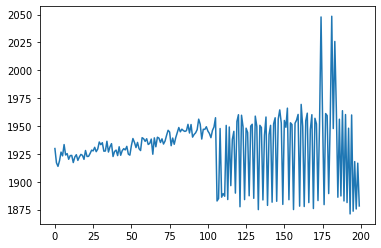

In [36]:
plt.plot(rewards_storage[:200])

In [44]:
autoencoder.save_weights('aenc_weights_15_06')

In [45]:
dqn_solver.model.Qpolicy.save_weights('dqn_weights_15_06')

In [82]:
rewards_storage

[-20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0,
 -20000.0]

In [39]:
autoencoder.weights[0][0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.28848872>

In [38]:
autoencoder.weights

[<tf.Variable 'encoder/dense_8/kernel:0' shape=(4, 16) dtype=float32, numpy=
 array([[ 0.6731519 ,  0.315793  ,  0.16822778, -0.64602506,  0.09252427,
          0.38910666,  0.5529649 ,  0.7776081 ,  0.5260435 , -0.02083748,
         -0.8276667 , -0.9061661 , -1.0689378 , -0.3018736 , -0.6993994 ,
         -0.17515428],
        [ 0.07484707,  0.7604488 ,  1.0857692 , -0.72904354,  1.1481678 ,
          0.11353139,  0.7276331 , -0.716265  ,  0.28851637, -0.46391103,
         -1.2036393 ,  0.01491096,  0.54008406,  0.31976607,  0.86139727,
         -1.0990291 ],
        [-0.6062149 ,  0.06246325,  1.9448066 , -0.55523854, -1.0286179 ,
         -1.2343662 ,  1.579112  ,  1.1748174 , -1.2951704 , -1.3161945 ,
          0.29519653, -0.5193821 , -0.9876179 ,  0.5980964 ,  0.6414352 ,
          1.1913831 ],
        [ 0.59264106,  1.1522578 ,  0.23224121,  1.1192757 , -0.74889004,
         -0.38891685,  0.5646799 ,  0.20139012,  0.5925846 ,  0.23720525,
         -0.6437281 , -0.8983016 ,  0.41

In [39]:
dqn_solver.model.Qpolicy.weights

[<tf.Variable 'dense/kernel:0' shape=(2, 512) dtype=float32, numpy=
 array([[-3.9430380e-02,  1.5977450e-02,  7.4159756e-02, ...,
          4.9249962e-02,  7.9693794e-02,  2.8441926e-02],
        [ 2.0170677e-02, -4.9086050e-03,  6.7629961e-05, ...,
          7.0236586e-02, -5.9554069e-03,  3.1821355e-02]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
 array([ 0.07315769,  0.07535834,  0.07893017,  0.08177733,  0.05829623,
         0.03290051,  0.03445258,  0.08520325,  0.08750124,  0.08724762,
         0.0863997 ,  0.08548895,  0.04879668,  0.03856827,  0.0842267 ,
         0.08641409,  0.08940197,  0.0732449 ,  0.08817407,  0.01088211,
         0.00654488,  0.06183248, -0.05338445,  0.05728047,  0.07967804,
         0.08267357,  0.08754292, -0.0419859 ,  0.09027503,  0.07130238,
        -0.00091506,  0.08214787,  0.06431732,  0.08290624,  0.03325573,
         0.08182754,  0.08855905,  0.08088741,  0.08521033,  0.04966574,
         0.08134913,  0.07

In [85]:
def complete_loop2(autoencoder,dqn_solver,epochs):
    for epoch in range(epochs):
        S_series,O_series,U_series,R_series,O_predicted_series,Done_series=data_collection(100,dqn_solver,autoencoder)
        print("epoch: {}, total reward: {}".format(epoch, sum(R_series)))
        rewards_storage.append(sum(R_series))
        dqn_training(dqn_solver,500,S_series,U_series,R_series,Done_series)
        dqn_solver.decrement_epsilon()
    

In [86]:
complete_loop2(autoencoder,dqn_solver,100)

epoch: 0, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.46it/s]


epoch: 1, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


epoch: 2, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


epoch: 3, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.64it/s]


epoch: 4, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.46it/s]


epoch: 5, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.63it/s]


epoch: 6, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.59it/s]


epoch: 7, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.58it/s]


epoch: 8, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.56it/s]


epoch: 9, total reward: -20000.0


100%|██████████| 500/500 [00:26<00:00, 19.23it/s]


epoch: 10, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.59it/s]


epoch: 11, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.59it/s]


epoch: 12, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.62it/s]


epoch: 13, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


epoch: 14, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.72it/s]


epoch: 15, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.71it/s]


epoch: 16, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.71it/s]


epoch: 17, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.62it/s]


epoch: 18, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.62it/s]


epoch: 19, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.58it/s]


epoch: 20, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.53it/s]


epoch: 21, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.71it/s]


epoch: 22, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.60it/s]


epoch: 23, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.68it/s]


epoch: 24, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.58it/s]


epoch: 25, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.69it/s]


epoch: 26, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.58it/s]


epoch: 27, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.69it/s]


epoch: 28, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.59it/s]


epoch: 29, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


epoch: 30, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.46it/s]


epoch: 31, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.28it/s]


epoch: 32, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.38it/s]


epoch: 33, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.40it/s]


epoch: 34, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.53it/s]


epoch: 35, total reward: -20000.0


100%|██████████| 500/500 [00:26<00:00, 18.75it/s]


epoch: 36, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


epoch: 37, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.42it/s]


epoch: 38, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.48it/s]


epoch: 39, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.42it/s]


epoch: 40, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.60it/s]


epoch: 41, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


epoch: 42, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.33it/s]


epoch: 43, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.41it/s]


epoch: 44, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.58it/s]


epoch: 45, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.45it/s]


epoch: 46, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


epoch: 47, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.51it/s]


epoch: 48, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.49it/s]


epoch: 49, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.35it/s]


epoch: 50, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.62it/s]


epoch: 51, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.66it/s]


epoch: 52, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


epoch: 53, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.26it/s]


epoch: 54, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.54it/s]


epoch: 55, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


epoch: 56, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.42it/s]


epoch: 57, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


epoch: 58, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.47it/s]


KeyboardInterrupt: 

In [91]:
for epoch in range(150):
        S_series,O_series,U_series,R_series,O_predicted_series,Done_series=data_collection(100,dqn_solver,autoencoder)
        print("epoch: {}, total reward: {}".format(epoch, sum(R_series)))
        rewards_storage.append(sum(R_series))
        dqn_training(dqn_solver,500,S_series,U_series,R_series,Done_series)
        dqn_solver.decrement_epsilon()

epoch: 0, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.83it/s]


epoch: 1, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.70it/s]


epoch: 2, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.67it/s]


epoch: 3, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.77it/s]


epoch: 4, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


epoch: 5, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.73it/s]


epoch: 6, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.83it/s]


epoch: 7, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 8, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.78it/s]


epoch: 9, total reward: -20000.0


100%|██████████| 500/500 [00:24<00:00, 20.01it/s]


epoch: 10, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


epoch: 11, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.89it/s]


epoch: 12, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.90it/s]


epoch: 13, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.85it/s]


epoch: 14, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.89it/s]


epoch: 15, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.82it/s]


epoch: 16, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 17, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.87it/s]


epoch: 18, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 19, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.91it/s]


epoch: 20, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.82it/s]


epoch: 21, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.89it/s]


epoch: 22, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.75it/s]


epoch: 23, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.87it/s]


epoch: 24, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.78it/s]


epoch: 25, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.93it/s]


epoch: 26, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 27, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


epoch: 28, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.78it/s]


epoch: 29, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


epoch: 30, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.68it/s]


epoch: 31, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.83it/s]


epoch: 32, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


epoch: 33, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.91it/s]


epoch: 34, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


epoch: 35, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.89it/s]


epoch: 36, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.76it/s]


epoch: 37, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.89it/s]


epoch: 38, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.85it/s]


epoch: 39, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 40, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.90it/s]


epoch: 41, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 42, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.85it/s]


epoch: 43, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.78it/s]


epoch: 44, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.83it/s]


epoch: 45, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.74it/s]


epoch: 46, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.76it/s]


epoch: 47, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 48, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.81it/s]


epoch: 49, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.87it/s]


epoch: 50, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 51, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 52, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.87it/s]


epoch: 53, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.78it/s]


epoch: 54, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.76it/s]


epoch: 55, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.75it/s]


epoch: 56, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


epoch: 57, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


epoch: 58, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.72it/s]


epoch: 59, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.89it/s]


epoch: 60, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.86it/s]


epoch: 61, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


epoch: 62, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.86it/s]


epoch: 63, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.86it/s]


epoch: 64, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.86it/s]


epoch: 65, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 66, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


epoch: 67, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


epoch: 68, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


epoch: 69, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


epoch: 70, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


epoch: 71, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.90it/s]


epoch: 72, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.86it/s]


epoch: 73, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.90it/s]


epoch: 74, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 75, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.78it/s]


epoch: 76, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.87it/s]


epoch: 77, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.86it/s]


epoch: 78, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.57it/s]


epoch: 79, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.92it/s]


epoch: 80, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 81, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


epoch: 82, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 83, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 84, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.81it/s]


epoch: 85, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.81it/s]


epoch: 86, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 87, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.79it/s]


epoch: 88, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.76it/s]


epoch: 89, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.87it/s]


epoch: 90, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 91, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.76it/s]


epoch: 92, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 93, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.90it/s]


epoch: 94, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.77it/s]


epoch: 95, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.74it/s]


epoch: 96, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 97, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 98, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.77it/s]


epoch: 99, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.85it/s]


epoch: 100, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.86it/s]


epoch: 101, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.45it/s]


epoch: 102, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.82it/s]


epoch: 103, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.84it/s]


epoch: 104, total reward: -20000.0


100%|██████████| 500/500 [00:24<00:00, 20.01it/s]


epoch: 105, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.88it/s]


epoch: 106, total reward: -20000.0


100%|██████████| 500/500 [00:25<00:00, 19.87it/s]


KeyboardInterrupt: 

In [46]:
len(rewards_storage)

209

In [47]:
df=pd.DataFrame(rewards_storage)
df.to_csv('main_algo_rwards_15_06.csv')

In [88]:
dqn_solver.epsilon

0.16562303420562907

In [87]:
dqn_solver.model.Qpolicy.weights

[<tf.Variable 'dense_14/kernel:0' shape=(2, 512) dtype=float32, numpy=
 array([[-0.00252096,  0.03848692, -0.02190778, ...,  0.09136443,
          0.0293721 , -0.03295858],
        [ 0.03701446,  0.01326066, -0.01747512, ..., -0.00778788,
         -0.06749691,  0.00432175]], dtype=float32)>,
 <tf.Variable 'dense_14/bias:0' shape=(512,) dtype=float32, numpy=
 array([ 0.0392588 ,  0.08111331,  0.03930321,  0.08249678,  0.08852978,
         0.1003061 ,  0.09508841,  0.02759516, -0.02136076, -0.04557455,
         0.10039402,  0.07909303,  0.0409503 ,  0.01677742,  0.09302708,
         0.06248408,  0.09295896,  0.08565139, -0.08353998,  0.1049431 ,
        -0.01742033,  0.07916331, -0.02780224, -0.07138257,  0.0801153 ,
         0.09020024,  0.09227141,  0.08081558,  0.10063373,  0.09541281,
         0.04669924, -0.08452012,  0.07728814,  0.08680708,  0.07750688,
         0.09010346,  0.02011451,  0.05711263,  0.06628156,  0.05659118,
         0.08171239,  0.00779219,  0.08488383,  0.090483

In [ ]:
# x=tf.concat((S_series[3-1],O_series[3],U_series[3-1]),axis=1)
# print(x)

In [ ]:
# print(loss(autoencoder,x,O_series[4],U_series[3]))

In [ ]:
#plt.plot(rewards_storage)

In [ ]:
for i,val in enumerate(rewards_storage):
    if (val>10000):
        print("{} , {}".format(i,val))

In [ ]:
# y=rewards_storage
# x=[float(i) for i in range (1,len(rewards_storage)+1)]
# x=np.array(x)
# m,b=np.polyfit(x,y,1)
# plt.plot(rewards_storage)
# plt.plot(x,m*x+b)

In [ ]:
df=pd.DataFrame(rewards_storage)
df.to_csv('rewards_final_main.csv')

In [ ]:
# df_avg=df.rolling(window=10).mean()
# plt.plot(df_avg)

In [89]:
plt.rcParams['figure.figsize']=[20,10]

In [90]:
t1=[x[0][0] for x in O_series[0:1000]]
t2=[x[0][0] for x in O_predicted_series[0:1000]]
plt.plot(t1)
plt.plot(t2)

NameError: name 'O_series' is not defined